Header Files

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


In [2]:
%run "D:/Athreya/Git_folders/DML-Project/dml_function/DL_functions.py"

Data Reading

In [3]:
B05 = pd.read_csv('../Battery_data/B0005_discharge_.csv')
B06 = pd.read_csv('../Battery_data/B0006_discharge_.csv')
B07 = pd.read_csv('../Battery_data/B0007_discharge.csv')
B18 = pd.read_csv('../Battery_data/B0018_discharge_.csv')

# print the first few rows
print(B05.head(0))
B05.shape
df = B05  # assigning B05 as the data we are concerned about


Empty DataFrame
Columns: [cycle, ambient_temperature, capacity, voltage_measured, current_measured, temperature_measured, current_load, voltage_load, time, RUL]
Index: []


Data visualization

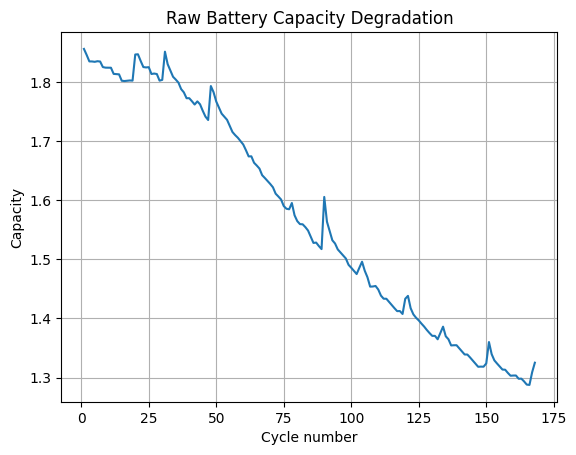

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['cycle'], df['capacity'])
plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Raw Battery Capacity Degradation')
plt.grid(True)
plt.show()

Parameter Evaluation

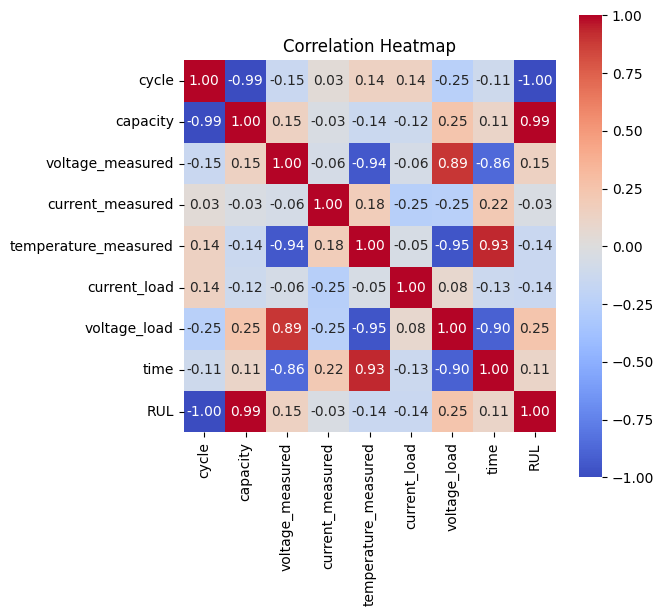

In [5]:
corr = df[['cycle','capacity','voltage_measured','current_measured','temperature_measured','current_load','voltage_load','time','RUL']].corr(method='spearman')
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()



 # DATA PREPROCESSING
Identifying the necessary features as inputs except cycles


In [6]:
# list of input sequences (per cycle)
feature_cols = ["voltage_measured", "current_measured", "temperature_measured",
                "current_load", "voltage_load", "time"]

Group by cycles

In [7]:
x_data, y_data = [], []
for cycle, group in df.groupby("cycle"):
    x_data.append(group[feature_cols].values)
    y_data.append(group["capacity"].iloc[-1])

Pad the group to make it equal sized

In [8]:
# pad sequences to same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_data = pad_sequences(x_data, dtype='float32', padding='pre')
y_data = np.array(y_data, dtype='float32')

Data Splitting

In [9]:
from sklearn.model_selection import train_test_split

X_, x_test, Y_, y_test = train_test_split(x_data,y_data,test_size = 0.1, shuffle = False)
x_train, x_val, y_train, y_val = train_test_split(X_,Y_,test_size = 0.1, shuffle = False)


Scaling (done after grouping and splitting the data, so that there is no data leakage)

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

num_features = x_train.shape[2]
scalers = [MinMaxScaler() for _ in range(num_features)]

# Scale the training data
for i in range(num_features):
    scalers[i].fit(x_train[:, :, i])
    x_train[:, :, i] = scalers[i].transform(x_train[:, :, i])
    x_val[:, :, i] = scalers[i].transform(x_val[:, :, i])
    x_test[:, :, i] = scalers[i].transform(x_test[:, :, i])

# Scale target column
target_scaler = MinMaxScaler().fit(y_train.reshape(-1, 1))
y_train = target_scaler.transform(y_train.reshape(-1, 1)).flatten()
y_val = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

Create DataLoaders

In [11]:
batch_size = 16
train_ds = DS(x_train,y_train)
val_ds = DS(x_val,y_val)
test_ds = DS(x_test,y_test)
train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=False)
test_loader = DataLoader(test_ds, batch_size, shuffle=False)

# GRU Model 
Training and validation

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = x_train.shape[2]
hidden_size = 64
output_size = 1
num_epochs = 50

# model = GRULayer(input_size, hidden_size, output_size).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_losses, val_losses = train_n_validate(
#     model, train_loader, val_loader, num_epochs, optimizer, criterion, device
# )




Save the model

In [13]:
# torch.save(model.state_dict(), "battery_rul_model.pt")
# torch.save({'train_losses': train_losses, 'val_losses': val_losses}, 'losses.pth')

Call the model

In [14]:
model = GRULayer(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("battery_rul_model.pt"))
model.eval()  # Set to evaluation mode
loaded = torch.load('losses.pth')
train_losses = loaded['train_losses']
val_losses = loaded['val_losses']

C:\Users\talla\AppData\Local\Temp\ipykernel_12696\1584485026.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("battery_rul_model.pt"))
C:

Plot the training parameters

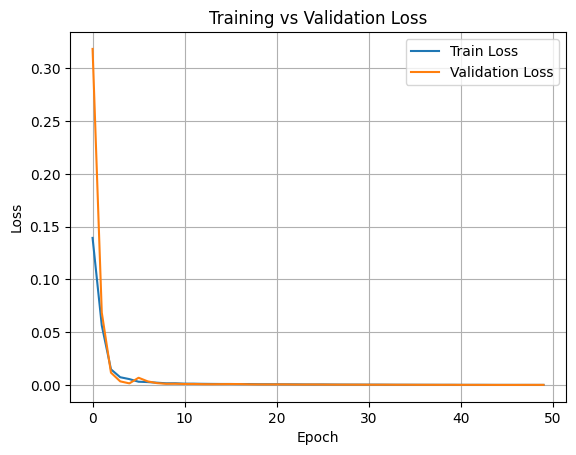

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Model Validation

Plotting the prediction

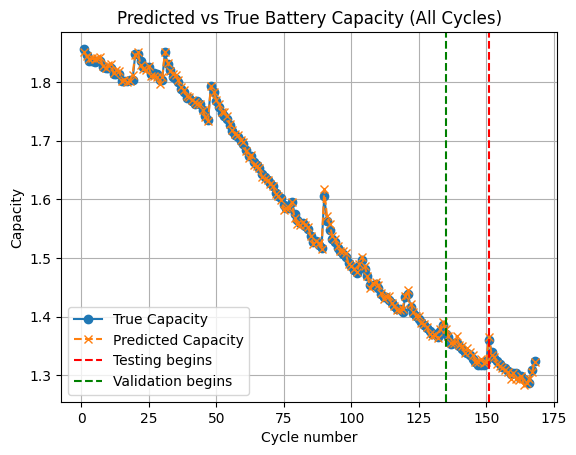

In [16]:
y_all_true = np.concatenate([y_train,y_val,y_test])
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(np.concatenate([x_train,x_val,x_test]), dtype=torch.float32).to(device)
    _,_,y_pred = model(X_tensor)
y_pred = y_pred.cpu().squeeze().numpy()

y_pred_unscaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_unscaled = target_scaler.inverse_transform(y_all_true.reshape(-1, 1)).flatten()

cycles = np.arange(1, len(y_all_true) + 1)

plt.figure()
plt.plot(cycles, y_true_unscaled, 'o-', label='True Capacity')
plt.plot(cycles, y_pred_unscaled, 'x--', label='Predicted Capacity')
test_start = len(y_train) + len(y_val)
plt.axvline(x=test_start, color='red', linestyle='--', label='Testing begins')
val_start = len(y_train)
plt.axvline(x=val_start, color='green', linestyle='--', label='Validation begins')

plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (All Cycles)')
plt.legend()
plt.grid(True)
plt.show()


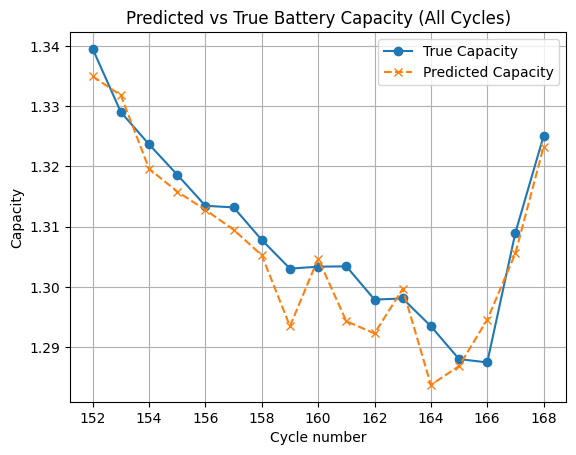

In [26]:
model.eval()
with torch.no_grad():
    X_tensor_tst = torch.tensor(x_test, dtype=torch.float32).to(device)
    _,_,y_pred_tst = model(X_tensor_tst)
y_pred_tst = y_pred_tst.cpu().squeeze().numpy()
cycles_tst = np.arange(test_start+1, len(y_all_true) + 1)


y_pred_unscaled_tst = target_scaler.inverse_transform(y_pred_tst.reshape(-1, 1)).flatten()
y_true_unscaled_tst = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
plt.figure()
plt.plot(cycles_tst, y_true_unscaled_tst, 'o-', label='True Capacity')
plt.plot(cycles_tst, y_pred_unscaled_tst, 'x--', label='Predicted Capacity')


plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (All Cycles)')
plt.legend()
plt.grid(True)
plt.show()


Compute the performance

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true_unscaled_tst, y_pred_unscaled_tst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_unscaled_tst, y_pred_unscaled_tst)
r2 = r2_score(y_true_unscaled_tst, y_pred_unscaled_tst)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 0.0000
RMSE = 0.0051
MAE  = 0.0042
R²   = 0.8699


# LSTM

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers




class BatteryLSTM(layers.Layer):
    """
    Custom LSTM layer with an optional regularizer and dropout.
    Equivalent to: layers.LSTM(64, return_sequences=False)
    """
    def __init__(self, hidden_units, dropout_rate, l2_reg):
        super(BatteryLSTM, self).__init__()
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg

        # Internal LSTM
        self.lstm = layers.LSTM(
            hidden_units,
            return_sequences=False,
            kernel_regularizer=regularizers.l2(l2_reg)
        )

        # Dropout layer (optional)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        """
        Forward pass — equivalent to PyTorch's forward()
        """
        x = self.lstm(inputs)
        x = self.dropout(x, training=training)
        return x
    

In [20]:
# LSTM

model_lstm = models.Sequential([BatteryLSTM(hidden_units=64, dropout_rate=0.0, l2_reg=0.0), layers.Dense(32, activation='relu'), layers.Dense(1)])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_lstm.compile(optimizer=optimizer, loss='mse')
max_len = 30       # your window size
n_features = 6     # your input feature count
# Build and print summary
model_lstm.build(input_shape=(None, max_len, n_features))
model_lstm.summary()


history = model_lstm.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    batch_size=16)
y_pred_scaled_lstm = model_lstm.predict(X_tensor)
y_pred_lstm =  target_scaler.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1)).flatten()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ battery_lstm (BatteryLSTM)      │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0705 - val_loss: 0.0137
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0035 - val_loss: 0.0254
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0011 - val_loss: 4.9675e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0011 - val_loss: 5.2218e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.9555e-04 - val_loss: 0.0011
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.6116e-04 - val_loss: 3.7882e-04
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 5.2428e

# Comparison plot

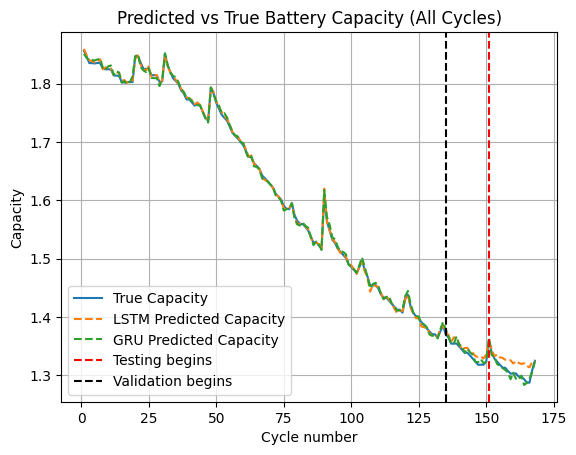

168

In [42]:
plt.figure()
plt.plot(cycles, y_true_unscaled, '-', label='True Capacity')
plt.plot(cycles, y_pred_lstm, '--', label='LSTM Predicted Capacity')
plt.plot(cycles, y_pred_unscaled, '--', label='GRU Predicted Capacity')
plt.axvline(x=test_start, color='red', linestyle='--', label='Testing begins')
plt.axvline(x=val_start, color='black', linestyle='--', label='Validation begins')


plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (All Cycles)')
plt.legend()
plt.grid(True)
plt.show()
len(cycles)

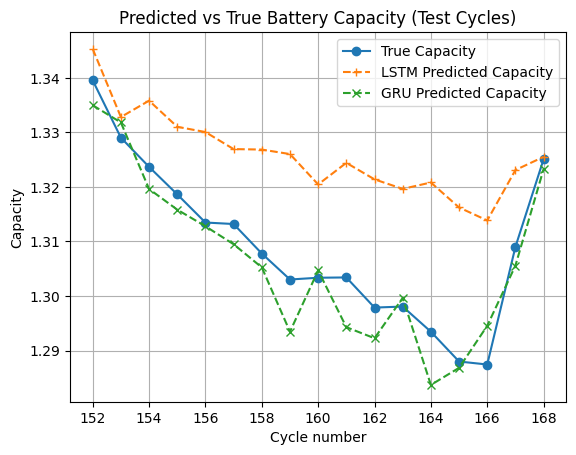

168

In [41]:
plt.figure()
plt.plot(cycles_tst, y_true_unscaled[test_start:], 'o-', label='True Capacity')
plt.plot(cycles_tst, y_pred_lstm[test_start:], '+--', label='LSTM Predicted Capacity')
plt.plot(cycles_tst, y_pred_unscaled[test_start:], 'x--', label='GRU Predicted Capacity')



plt.xlabel('Cycle number')
plt.ylabel('Capacity')
plt.title('Predicted vs True Battery Capacity (Test Cycles)')
plt.legend()
plt.grid(True)
plt.show()
len(cycles)

In [33]:
mse_lstm = mean_squared_error(y_true_unscaled_tst, y_pred_lstm[test_start:])
rmse_lstm = np.sqrt(mse)
mae_lstm = mean_absolute_error(y_true_unscaled_tst, y_pred_lstm[test_start:])
r2_lstm = r2_score(y_true_unscaled_tst, y_pred_lstm[test_start:])

results = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'LSTM': [mse_lstm, rmse_lstm, mae_lstm, r2_lstm],
    'GRU': [mse, rmse, mae, r2]
})

print(results)

  Metric      LSTM       GRU
0    MSE  0.000347  0.000026
1   RMSE  0.005120  0.005120
2    MAE  0.016827  0.004211
3     R² -0.719775  0.869944
